# Fraud Detection Transaksi Online
### End-to-End Classification Pipeline dengan GPU Acceleration

---

**Deskripsi:**  
Notebook ini membangun sistem deteksi fraud menggunakan CUDA untuk mempercepat proses training.

**Model yang digunakan:**
- Logistic Regression (Baseline - CPU)
- XGBoost dengan GPU CUDA
- Neural Network dengan PyTorch GPU

---
## 1. Import Libraries & Cek GPU

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, f1_score
)
from sklearn.utils import class_weight
import gdown
import joblib

# GPU Libraries
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Konfigurasi visual & reproducibility
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Setup direktori
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True, parents=True)

print(f'📁 Working Directory: {BASE_DIR}')
print(f'📁 Data Directory   : {DATA_DIR}')

📁 Working Directory: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1
📁 Data Directory   : c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\data


In [2]:
# ============================================
# CEK GPU / CUDA
# ============================================
print('='*50)
print('🖥️ GPU / CUDA STATUS')
print('='*50)

# PyTorch CUDA
print(f'\n📦 PyTorch Version: {torch.__version__}')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'✅ CUDA tersedia!')
    print(f'   GPU Name    : {torch.cuda.get_device_name(0)}')
    print(f'   CUDA Version: {torch.version.cuda}')
    print(f'   GPU Memory  : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    device = torch.device('cpu')
    print('⚠️ CUDA tidak tersedia, menggunakan CPU')

# XGBoost
print(f'\n📦 XGBoost Version: {xgb.__version__}')
print('='*50)

🖥️ GPU / CUDA STATUS

📦 PyTorch Version: 2.9.1+cu130
✅ CUDA tersedia!
   GPU Name    : NVIDIA GeForce GTX 1650
   CUDA Version: 13.0
   GPU Memory  : 4.3 GB

📦 XGBoost Version: 3.1.3


---
## 2. Muat Dataset

Dataset diambil dari Google Drive menggunakan gdown.

In [3]:
# Unduh dataset dari Google Drive
TRAIN_FILE_ID = '1I51CMcFKjzYaK2WzFmHhqXS-E9N9f5TF'
TEST_FILE_ID = '1H4z_aySFoGYi5MKzgLjgddUoRd0MG49x'

train_path = DATA_DIR / 'train_transaction.csv'
test_path = DATA_DIR / 'test_transaction.csv'

if not train_path.exists():
    print('⏬ Mengunduh train_transaction.csv...')
    gdown.download(f'https://drive.google.com/uc?id={TRAIN_FILE_ID}', str(train_path), quiet=False)
else:
    print('✅ train_transaction.csv sudah tersedia')

if not test_path.exists():
    print('⏬ Mengunduh test_transaction.csv...')
    gdown.download(f'https://drive.google.com/uc?id={TEST_FILE_ID}', str(test_path), quiet=False)
else:
    print('✅ test_transaction.csv sudah tersedia')

✅ train_transaction.csv sudah tersedia
✅ test_transaction.csv sudah tersedia


In [4]:
# Muat data
print('⏳ Memuat dataset...')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f'✅ Train: {train_df.shape[0]:,} baris, {train_df.shape[1]} kolom')
print(f'✅ Test : {test_df.shape[0]:,} baris, {test_df.shape[1]} kolom')

⏳ Memuat dataset...
✅ Train: 590,540 baris, 394 kolom
✅ Test : 506,691 baris, 393 kolom


---
## 3. Eksplorasi Data (EDA)

In [5]:
# Info dataset
print('📊 Info Dataset Training:')
print(f'   Shape: {train_df.shape}')
print(f'   Memory: {train_df.memory_usage(deep=True).sum() / 1e6:.1f} MB')

# Distribusi target
target_dist = train_df['isFraud'].value_counts()
target_pct = train_df['isFraud'].value_counts(normalize=True) * 100

print(f'\n📊 Distribusi Target:')
print(f'   Not Fraud (0): {target_dist[0]:,} ({target_pct[0]:.2f}%)')
print(f'   Fraud (1)    : {target_dist[1]:,} ({target_pct[1]:.2f}%)')
print(f'\n⚠️ Dataset sangat IMBALANCED! Rasio: 1:{target_dist[0]//target_dist[1]}')

📊 Info Dataset Training:
   Shape: (590540, 394)
   Memory: 2162.2 MB

📊 Distribusi Target:
   Not Fraud (0): 569,877 (96.50%)
   Fraud (1)    : 20,663 (3.50%)

⚠️ Dataset sangat IMBALANCED! Rasio: 1:27


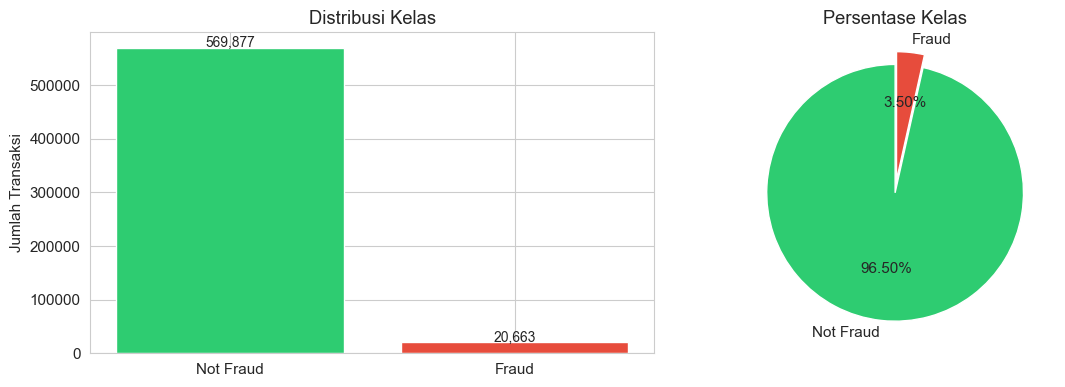

In [6]:
# Visualisasi distribusi target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Not Fraud', 'Fraud'], target_dist.values, color=colors)
axes[0].set_ylabel('Jumlah Transaksi')
axes[0].set_title('Distribusi Kelas')
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontsize=10)

axes[1].pie(target_pct.values, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%', 
            colors=colors, explode=[0, 0.1], startangle=90)
axes[1].set_title('Persentase Kelas')

plt.tight_layout()
plt.show()

---
## 4. Data Cleaning & Handling Missing Values

In [7]:
# Analisis missing values
missing_pct = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
missing_cols = missing_pct[missing_pct > 0]

print(f'📊 Kolom dengan Missing Values: {len(missing_cols)} dari {len(train_df.columns)}')
print(f'\nTop 10 kolom dengan missing tertinggi:')
print(missing_cols.head(10))

📊 Kolom dengan Missing Values: 374 dari 394

Top 10 kolom dengan missing tertinggi:
dist2    93.628374
D7       93.409930
D13      89.509263
D14      89.469469
D12      89.041047
D6       87.606767
D9       87.312290
D8       87.312290
V153     86.123717
V149     86.123717
dtype: float64


In [8]:
# Drop kolom dengan missing > 50%
MISSING_THRESHOLD = 50
cols_to_drop = missing_pct[missing_pct > MISSING_THRESHOLD].index.tolist()

print(f'🗑️ Menghapus {len(cols_to_drop)} kolom dengan missing > {MISSING_THRESHOLD}%')

train_processed = train_df.drop(columns=cols_to_drop)
test_processed = test_df.drop(columns=cols_to_drop, errors='ignore')

print(f'   Train shape: {train_processed.shape}')
print(f'   Test shape : {test_processed.shape}')

🗑️ Menghapus 174 kolom dengan missing > 50%
   Train shape: (590540, 220)
   Test shape : (506691, 219)


In [9]:
# Identifikasi tipe kolom
exclude_cols = ['TransactionID', 'isFraud']
feature_cols = [c for c in train_processed.columns if c not in exclude_cols]

numeric_cols = train_processed[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_processed[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f'📊 Jumlah fitur numerik   : {len(numeric_cols)}')
print(f'📊 Jumlah fitur kategorikal: {len(categorical_cols)}')

📊 Jumlah fitur numerik   : 209
📊 Jumlah fitur kategorikal: 9


In [10]:
# Imputasi missing values
print('🔧 Mengisi missing values...')

# Numerik: isi dengan median
for col in numeric_cols:
    if train_processed[col].isnull().sum() > 0:
        median_val = train_processed[col].median()
        train_processed[col] = train_processed[col].fillna(median_val)
        test_processed[col] = test_processed[col].fillna(median_val)

# Kategorikal: isi dengan mode atau 'Unknown'
for col in categorical_cols:
    if train_processed[col].isnull().sum() > 0:
        train_processed[col] = train_processed[col].fillna('Unknown')
        test_processed[col] = test_processed[col].fillna('Unknown')

print(f'✅ Missing values tersisa: {train_processed.isnull().sum().sum()}')

🔧 Mengisi missing values...
✅ Missing values tersisa: 0


---
## 5. Handling Outliers

Deteksi dan tangani outlier pada fitur numerik menggunakan metode IQR (Interquartile Range) dengan clipping.

In [11]:
# Analisis outlier pada fitur numerik
print('🔍 Analisis Outlier pada Fitur Numerik...')

# Pilih beberapa fitur numerik penting untuk analisis
key_numeric_cols = [col for col in numeric_cols if col in train_processed.columns][:10]

# Hitung statistik outlier menggunakan IQR
outlier_stats = []
for col in key_numeric_cols:
    Q1 = train_processed[col].quantile(0.25)
    Q3 = train_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    n_outliers = ((train_processed[col] < lower_bound) | (train_processed[col] > upper_bound)).sum()
    pct_outliers = n_outliers / len(train_processed) * 100
    
    outlier_stats.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower': lower_bound,
        'Upper': upper_bound,
        'N_Outliers': n_outliers,
        'Pct_Outliers': pct_outliers
    })

outlier_df = pd.DataFrame(outlier_stats)
print(f'\n📊 Statistik Outlier (Top 10 fitur numerik):')
print(outlier_df[['Feature', 'N_Outliers', 'Pct_Outliers']].to_string(index=False))

🔍 Analisis Outlier pada Fitur Numerik...

📊 Statistik Outlier (Top 10 fitur numerik):
       Feature  N_Outliers  Pct_Outliers
 TransactionDT           0      0.000000
TransactionAmt       66482     11.257832
         card1           0      0.000000
         card2           0      0.000000
         card3       67688     11.462052
         card5           0      0.000000
         addr1        8807      1.491347
         addr2        4353      0.737122
            C1       59535     10.081451
            C2       62214     10.535103


In [12]:
# Handling outlier dengan clipping (percentile 1% - 99%)
print('🔧 Menerapkan clipping outlier pada persentil 1% - 99%...')

outlier_cols = [col for col in numeric_cols if col in train_processed.columns]

for col in outlier_cols:
    lower = train_processed[col].quantile(0.01)
    upper = train_processed[col].quantile(0.99)
    
    train_processed[col] = train_processed[col].clip(lower=lower, upper=upper)
    test_processed[col] = test_processed[col].clip(lower=lower, upper=upper)

print(f'✅ Outlier clipping selesai untuk {len(outlier_cols)} fitur numerik')

🔧 Menerapkan clipping outlier pada persentil 1% - 99%...
✅ Outlier clipping selesai untuk 209 fitur numerik


---
## 6. Feature Engineering

Membuat fitur-fitur baru dari data yang ada untuk meningkatkan kemampuan prediksi model.

In [13]:
# ============================================
# FEATURE ENGINEERING
# ============================================
print('🔧 Membuat fitur baru...')

# 1. Fitur dari TransactionAmt (jika ada)
if 'TransactionAmt' in train_processed.columns:
    # Log transform untuk amount (mengurangi skewness)
    train_processed['TransactionAmt_Log'] = np.log1p(train_processed['TransactionAmt'])
    test_processed['TransactionAmt_Log'] = np.log1p(test_processed['TransactionAmt'])
    
    # Binning amount ke kategori
    train_processed['TransactionAmt_Bin'] = pd.qcut(train_processed['TransactionAmt'], q=10, labels=False, duplicates='drop')
    test_processed['TransactionAmt_Bin'] = pd.qcut(test_processed['TransactionAmt'], q=10, labels=False, duplicates='drop')
    
    print('   ✅ TransactionAmt_Log, TransactionAmt_Bin')

# 2. Fitur dari TransactionDT (waktu transaksi, jika ada)
if 'TransactionDT' in train_processed.columns:
    # Ekstrak komponen waktu
    train_processed['Hour'] = (train_processed['TransactionDT'] // 3600) % 24
    train_processed['DayOfWeek'] = (train_processed['TransactionDT'] // 86400) % 7
    train_processed['IsWeekend'] = (train_processed['DayOfWeek'] >= 5).astype(int)
    train_processed['IsNight'] = ((train_processed['Hour'] >= 22) | (train_processed['Hour'] <= 6)).astype(int)
    
    test_processed['Hour'] = (test_processed['TransactionDT'] // 3600) % 24
    test_processed['DayOfWeek'] = (test_processed['TransactionDT'] // 86400) % 7
    test_processed['IsWeekend'] = (test_processed['DayOfWeek'] >= 5).astype(int)
    test_processed['IsNight'] = ((test_processed['Hour'] >= 22) | (test_processed['Hour'] <= 6)).astype(int)
    
    print('   ✅ Hour, DayOfWeek, IsWeekend, IsNight')

# 3. Fitur agregat dari kolom V (jika ada)
v_cols = [col for col in train_processed.columns if col.startswith('V') and col[1:].isdigit()]
if len(v_cols) > 0:
    train_processed['V_mean'] = train_processed[v_cols].mean(axis=1)
    train_processed['V_std'] = train_processed[v_cols].std(axis=1)
    train_processed['V_sum'] = train_processed[v_cols].sum(axis=1)
    
    test_processed['V_mean'] = test_processed[v_cols].mean(axis=1)
    test_processed['V_std'] = test_processed[v_cols].std(axis=1)
    test_processed['V_sum'] = test_processed[v_cols].sum(axis=1)
    
    print(f'   ✅ V_mean, V_std, V_sum (dari {len(v_cols)} kolom V)')

# 4. Fitur agregat dari kolom C (jika ada)
c_cols = [col for col in train_processed.columns if col.startswith('C') and col[1:].isdigit()]
if len(c_cols) > 0:
    train_processed['C_mean'] = train_processed[c_cols].mean(axis=1)
    train_processed['C_std'] = train_processed[c_cols].std(axis=1)
    
    test_processed['C_mean'] = test_processed[c_cols].mean(axis=1)
    test_processed['C_std'] = test_processed[c_cols].std(axis=1)
    
    print(f'   ✅ C_mean, C_std (dari {len(c_cols)} kolom C)')

# 5. Fitur agregat dari kolom D (jika ada)
d_cols = [col for col in train_processed.columns if col.startswith('D') and col[1:].isdigit()]
if len(d_cols) > 0:
    train_processed['D_mean'] = train_processed[d_cols].mean(axis=1)
    train_processed['D_std'] = train_processed[d_cols].std(axis=1)
    
    test_processed['D_mean'] = test_processed[d_cols].mean(axis=1)
    test_processed['D_std'] = test_processed[d_cols].std(axis=1)
    
    print(f'   ✅ D_mean, D_std (dari {len(d_cols)} kolom D)')

# Update daftar fitur
new_cols = [col for col in train_processed.columns if col not in exclude_cols]
print(f'\\n✅ Total fitur setelah engineering: {len(new_cols)}')

🔧 Membuat fitur baru...
   ✅ TransactionAmt_Log, TransactionAmt_Bin
   ✅ Hour, DayOfWeek, IsWeekend, IsNight
   ✅ V_mean, V_std, V_sum (dari 180 kolom V)
   ✅ C_mean, C_std (dari 14 kolom C)
   ✅ D_mean, D_std (dari 7 kolom D)
\n✅ Total fitur setelah engineering: 231


---
## 7. Feature Selection

Seleksi fitur berdasarkan korelasi dengan target dan encoding fitur kategorikal.

In [14]:
# Encode categorical columns
print('🔧 Encoding fitur kategorikal...')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Gabungkan train & test untuk encoding konsisten
    combined = pd.concat([train_processed[col], test_processed[col]], axis=0).astype(str)
    le.fit(combined)
    
    train_processed[col] = le.transform(train_processed[col].astype(str))
    test_processed[col] = le.transform(test_processed[col].astype(str))
    label_encoders[col] = le

print(f'✅ {len(categorical_cols)} kolom kategorikal berhasil di-encode')

🔧 Encoding fitur kategorikal...
✅ 9 kolom kategorikal berhasil di-encode


In [15]:
# Feature selection berdasarkan korelasi dengan target
print('🔍 Seleksi fitur berdasarkan korelasi...')

# Update feature columns setelah encoding
feature_cols = [c for c in train_processed.columns if c not in exclude_cols]

# Hitung korelasi dengan target
correlations = train_processed[feature_cols].corrwith(train_processed['isFraud']).abs()
correlations = correlations.sort_values(ascending=False)

# Pilih fitur dengan korelasi > threshold
CORR_THRESHOLD = 0.01
selected_features = correlations[correlations > CORR_THRESHOLD].index.tolist()

print(f'✅ Fitur terpilih: {len(selected_features)} dari {len(feature_cols)}')
print(f'\nTop 15 fitur dengan korelasi tertinggi:')
for i, (feat, corr) in enumerate(correlations.head(15).items(), 1):
    print(f'   {i:2d}. {feat:25s} : {corr:.4f}')

🔍 Seleksi fitur berdasarkan korelasi...
✅ Fitur terpilih: 186 dari 231

Top 15 fitur dengan korelasi tertinggi:
    1. C7                        : 0.2533
    2. C12                       : 0.2512
    3. C4                        : 0.2498
    4. C8                        : 0.2407
    5. C10                       : 0.2082
    6. V45                       : 0.2003
    7. V87                       : 0.1819
    8. V40                       : 0.1726
    9. card3                     : 0.1659
   10. V94                       : 0.1615
   11. V43                       : 0.1591
   12. V44                       : 0.1588
   13. V33                       : 0.1584
   14. V34                       : 0.1578
   15. V79                       : 0.1573


---
## 8. Split Data & Preprocessing

In [16]:
# Siapkan data
X = train_processed[selected_features]
y = train_processed['isFraud']
X_test_final = test_processed[selected_features]
test_ids = test_processed['TransactionID']

# Split train-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'📊 Training set  : {X_train.shape[0]:,} sampel')
print(f'📊 Validation set: {X_val.shape[0]:,} sampel')
print(f'📊 Test set      : {X_test_final.shape[0]:,} sampel')
print(f'📊 Jumlah fitur  : {X_train.shape[1]}')

📊 Training set  : 472,432 sampel
📊 Validation set: 118,108 sampel
📊 Test set      : 506,691 sampel
📊 Jumlah fitur  : 186


In [17]:
# Normalisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

# Hitung class weights untuk imbalanced data
class_weights_arr = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = {0: class_weights_arr[0], 1: class_weights_arr[1]}
sample_weights = y_train.map(class_weight_dict)

print(f'⚖️ Class Weights: {class_weight_dict}')

⚖️ Class Weights: {0: np.float64(0.5181288961224123), 1: np.float64(14.290139140955837)}


In [18]:
# Fungsi evaluasi untuk klasifikasi
def evaluate_classifier(y_true, y_pred, y_proba, model_name='Model'):
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    
    print(f'📊 Evaluasi {model_name}:')
    print(f'   ROC-AUC: {roc_auc:.4f}')
    print(f'   PR-AUC : {pr_auc:.4f}')
    print(f'   F1-Score: {f1:.4f}')
    
    return {'ROC-AUC': roc_auc, 'PR-AUC': pr_auc, 'F1': f1}

---
## 9. Model Baseline: Logistic Regression

In [19]:
# Logistic Regression (CPU)
print('🚀 Melatih Logistic Regression (Baseline)...')
start_time = time.time()

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train)

lr_time = time.time() - start_time
print(f'⏱️ Waktu training: {lr_time:.2f} detik')

# Prediksi & Evaluasi
lr_pred = lr_model.predict(X_val_scaled)
lr_proba = lr_model.predict_proba(X_val_scaled)[:, 1]
lr_metrics = evaluate_classifier(y_val, lr_pred, lr_proba, 'Logistic Regression')

🚀 Melatih Logistic Regression (Baseline)...
⏱️ Waktu training: 29.73 detik
📊 Evaluasi Logistic Regression:
   ROC-AUC: 0.8555
   PR-AUC : 0.3645
   F1-Score: 0.2192


---
## 10. Model XGBoost dengan GPU + Hyperparameter Tuning 

XGBoost dengan `device='cuda'` untuk akselerasi GPU.

In [20]:
# ============================================
# HYPERPARAMETER TUNING untuk XGBoost
# ============================================
print('🔧 Hyperparameter Tuning XGBoost dengan GPU...')
print('='*50)

# Gunakan subset untuk tuning (lebih cepat)
subset_frac = 0.3
subset_idx = np.random.choice(len(X_train_scaled), size=int(len(X_train_scaled) * subset_frac), replace=False)
X_sub = X_train_scaled[subset_idx]
y_sub = y_train.iloc[subset_idx]

# Parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, 5, 10, 20]  # Untuk imbalanced data
}

# Base model untuk tuning
xgb_base = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=RANDOM_STATE,
    verbosity=0,
    use_label_encoder=False,
    eval_metric='auc'
)

# RandomizedSearchCV
start_tune = time.time()
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=1,
    verbose=1
)

random_search.fit(X_sub, y_sub)
tune_time = time.time() - start_tune

print('='*50)
print(f'✅ Tuning selesai dalam {tune_time:.1f} detik!')

🔧 Hyperparameter Tuning XGBoost dengan GPU...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Tuning selesai dalam 140.3 detik!


In [21]:
# Tampilkan best parameters
best_params = random_search.best_params_
print('🏆 Best Parameters:')
for param, value in best_params.items():
    print(f'   {param}: {value}')

print(f'\n📊 Best CV ROC-AUC: {random_search.best_score_:.4f}')

🏆 Best Parameters:
   subsample: 0.9
   scale_pos_weight: 1
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.05
   colsample_bytree: 0.9

📊 Best CV ROC-AUC: 0.9206


In [22]:
# Training XGBoost dengan Best Parameters
print('🚀 Melatih XGBoost dengan Best Parameters (GPU CUDA)...')
print('='*50)
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    random_state=RANDOM_STATE,
    verbosity=1,
    use_label_encoder=False,
    eval_metric='auc'
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=50
)

xgb_time = time.time() - start_time
print('='*50)
print(f'✅ Training selesai dalam {xgb_time:.1f} detik!')

🚀 Melatih XGBoost dengan Best Parameters (GPU CUDA)...
[0]	validation_0-auc:0.85172
[50]	validation_0-auc:0.92714
[100]	validation_0-auc:0.94463
[150]	validation_0-auc:0.95145
[199]	validation_0-auc:0.95547
✅ Training selesai dalam 16.1 detik!


In [23]:
# Evaluasi XGBoost
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
xgb_metrics = evaluate_classifier(y_val, xgb_pred, xgb_proba, 'XGBoost (GPU)')

📊 Evaluasi XGBoost (GPU):
   ROC-AUC: 0.9555
   PR-AUC : 0.7723
   F1-Score: 0.6738


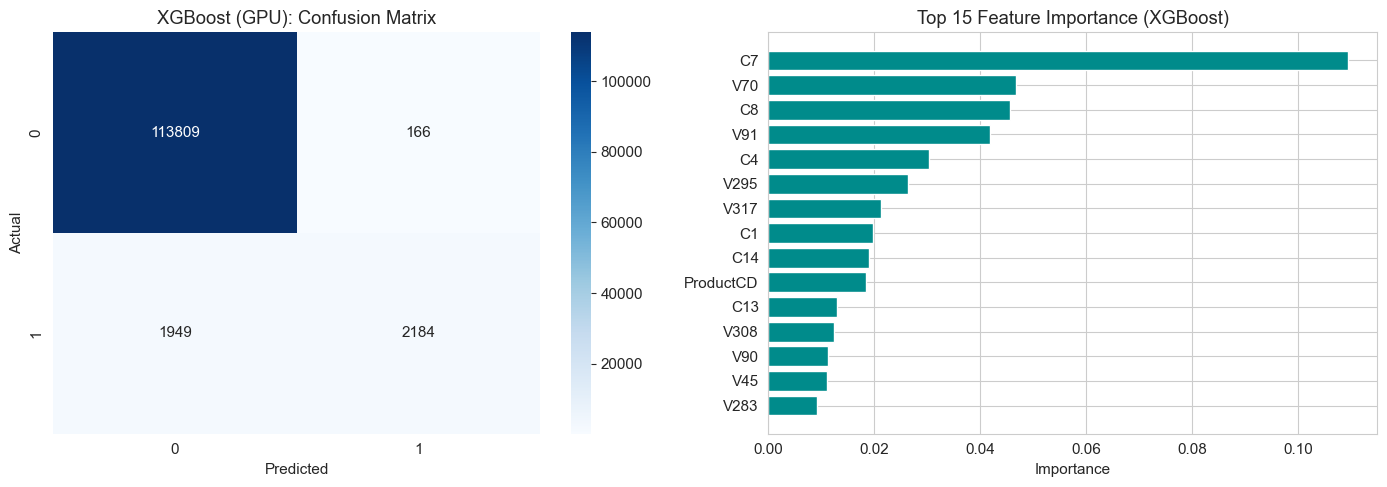

In [24]:
# Visualisasi XGBoost
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('XGBoost (GPU): Confusion Matrix')

# Feature Importance
importances = xgb_model.feature_importances_
top_n = min(15, len(selected_features))
top_idx = np.argsort(importances)[-top_n:]
axes[1].barh([selected_features[i] for i in top_idx], importances[top_idx], color='darkcyan')
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Top {top_n} Feature Importance (XGBoost)')

plt.tight_layout()
plt.show()

---
## 11. Model Neural Network dengan PyTorch GPU 

Deep learning untuk fraud detection dengan GPU CUDA.

In [25]:
# Definisi Neural Network untuk Classification
class FraudDetectionNN(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

print(f'🖥️ Device untuk training: {device}')

🖥️ Device untuk training: cuda


In [26]:
# Persiapan data untuk PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)

# Buat sample weights tensor
weights_tensor = torch.FloatTensor(sample_weights.values).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, weights_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

print(f'✅ Data tensor siap di {device}')
print(f'   X_train: {X_train_tensor.shape}')
print(f'   y_train: {y_train_tensor.shape}')

✅ Data tensor siap di cuda
   X_train: torch.Size([472432, 186])
   y_train: torch.Size([472432, 1])


In [27]:
# Inisialisasi model
input_dim = X_train_scaled.shape[1]
nn_model = FraudDetectionNN(input_dim).to(device)

# Loss function dengan class weight untuk imbalanced data
pos_weight = torch.tensor([class_weight_dict[1] / class_weight_dict[0]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f'📊 Model Architecture:')
print(f'   Input dimension : {input_dim}')
print(f'   Total parameters: {sum(p.numel() for p in nn_model.parameters()):,}')

📊 Model Architecture:
   Input dimension : 186
   Total parameters: 92,033


In [28]:
# Training Neural Network
EPOCHS = 50
best_auc = 0
history = {'train_loss': [], 'val_auc': []}
patience_counter = 0
EARLY_STOP_PATIENCE = 10

print(f'🚀 Training Neural Network di {device}...')
print('='*50)
start_time = time.time()

for epoch in range(EPOCHS):
    # Training
    nn_model.train()
    train_loss = 0
    
    for batch_X, batch_y, batch_w in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        # Weighted loss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader)
    
    # Validation
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_proba = val_outputs.cpu().numpy().flatten()
        val_auc = roc_auc_score(y_val, val_proba)
    
    scheduler.step(1 - val_auc)  # Minimize 1-AUC
    history['train_loss'].append(avg_loss)
    history['val_auc'].append(val_auc)
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(nn_model.state_dict(), BASE_DIR / 'fraud_nn_best.pt')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'   Epoch {epoch+1:3d}/{EPOCHS} | Loss: {avg_loss:.4f} | Val AUC: {val_auc:.4f}')
    
    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f'\n⚠️ Early stopping di epoch {epoch+1}')
        break

nn_time = time.time() - start_time
print('='*50)
print(f'✅ Training selesai dalam {nn_time:.1f} detik!')
print(f'🏆 Best Validation AUC: {best_auc:.4f}')

🚀 Training Neural Network di cuda...
   Epoch   5/50 | Loss: 1.1515 | Val AUC: 0.8591
   Epoch  10/50 | Loss: 1.1402 | Val AUC: 0.8622
   Epoch  15/50 | Loss: 1.1341 | Val AUC: 0.8715
   Epoch  20/50 | Loss: 1.1285 | Val AUC: 0.8738
   Epoch  25/50 | Loss: 1.1258 | Val AUC: 0.8786
   Epoch  30/50 | Loss: 1.1175 | Val AUC: 0.8838
   Epoch  35/50 | Loss: 1.1131 | Val AUC: 0.8856
   Epoch  40/50 | Loss: 1.1106 | Val AUC: 0.8815
   Epoch  45/50 | Loss: 1.1052 | Val AUC: 0.8855
   Epoch  50/50 | Loss: 1.1030 | Val AUC: 0.8882
✅ Training selesai dalam 422.6 detik!
🏆 Best Validation AUC: 0.8882


In [29]:
# Load best model & evaluasi
nn_model.load_state_dict(torch.load(BASE_DIR / 'fraud_nn_best.pt'))
nn_model.eval()

with torch.no_grad():
    nn_proba = nn_model(X_val_tensor).cpu().numpy().flatten()
    nn_pred = (nn_proba > 0.5).astype(int)

nn_metrics = evaluate_classifier(y_val, nn_pred, nn_proba, 'Neural Network (GPU)')

📊 Evaluasi Neural Network (GPU):
   ROC-AUC: 0.8882
   PR-AUC : 0.4788
   F1-Score: 0.4106


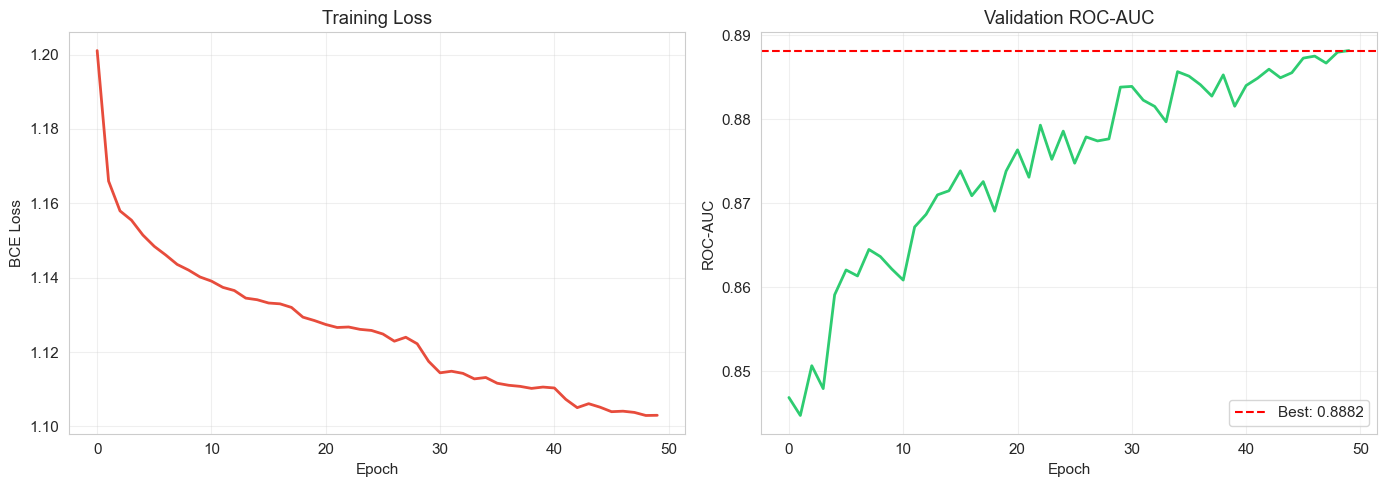

In [30]:
# Visualisasi Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
axes[0].plot(history['train_loss'], color='#e74c3c', lw=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Validation AUC
axes[1].plot(history['val_auc'], color='#2ecc71', lw=2)
axes[1].axhline(y=best_auc, color='red', linestyle='--', label=f'Best: {best_auc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Validation ROC-AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 12. Perbandingan Semua Model

In [31]:
# Tabel perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression (CPU)', 'XGBoost (GPU)', 'Neural Network (GPU)'],
    'ROC-AUC': [lr_metrics['ROC-AUC'], xgb_metrics['ROC-AUC'], nn_metrics['ROC-AUC']],
    'PR-AUC': [lr_metrics['PR-AUC'], xgb_metrics['PR-AUC'], nn_metrics['PR-AUC']],
    'F1-Score': [lr_metrics['F1'], xgb_metrics['F1'], nn_metrics['F1']],
    'Training Time (s)': [lr_time, xgb_time, nn_time]
})

print('📊 PERBANDINGAN PERFORMA MODEL')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)

📊 PERBANDINGAN PERFORMA MODEL
                    Model  ROC-AUC   PR-AUC  F1-Score  Training Time (s)
Logistic Regression (CPU) 0.855450 0.364539  0.219189          29.732845
            XGBoost (GPU) 0.955466 0.772278  0.673762          16.093956
     Neural Network (GPU) 0.888156 0.478765  0.410638         422.551806


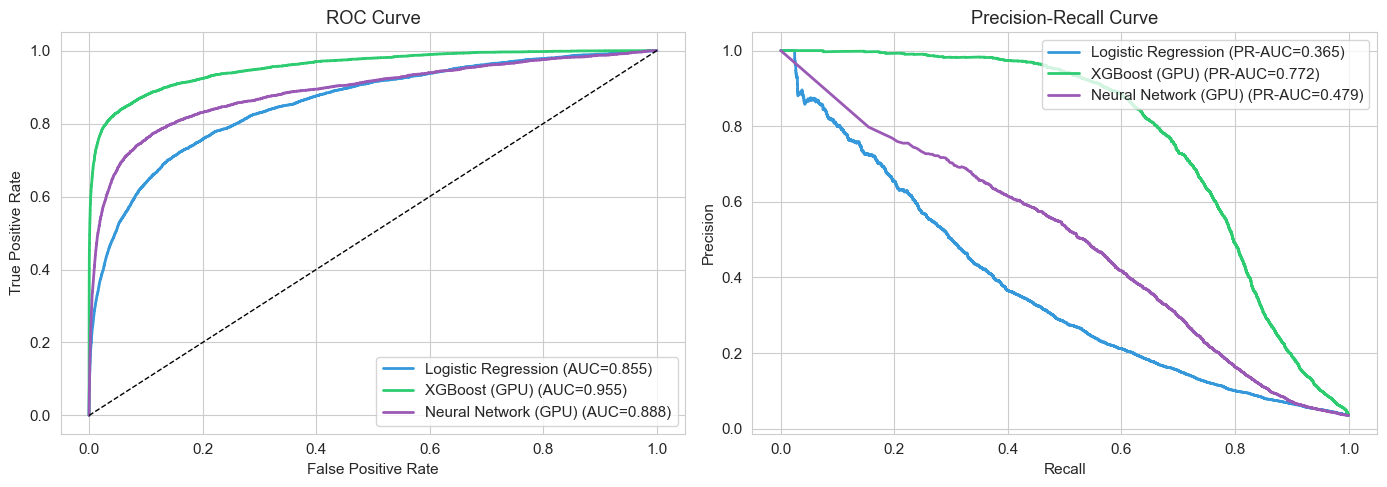

In [32]:
# Visualisasi ROC Curve semua model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
for name, proba, color in [('Logistic Regression', lr_proba, '#3498db'),
                            ('XGBoost (GPU)', xgb_proba, '#2ecc71'),
                            ('Neural Network (GPU)', nn_proba, '#9b59b6')]:
    fpr, tpr, _ = roc_curve(y_val, proba)
    auc = roc_auc_score(y_val, proba)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, lw=2)

axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')

# Precision-Recall Curve
for name, proba, color in [('Logistic Regression', lr_proba, '#3498db'),
                            ('XGBoost (GPU)', xgb_proba, '#2ecc71'),
                            ('Neural Network (GPU)', nn_proba, '#9b59b6')]:
    precision, recall, _ = precision_recall_curve(y_val, proba)
    pr_auc = average_precision_score(y_val, proba)
    axes[1].plot(recall, precision, label=f'{name} (PR-AUC={pr_auc:.3f})', color=color, lw=2)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

---
## 13. Prediksi & Submission

In [33]:
# Pilih model terbaik berdasarkan ROC-AUC
best_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']

print(f'🏆 Model terbaik: {best_model_name}')

# Prediksi dengan model terbaik
if 'XGBoost' in best_model_name:
    final_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
elif 'Neural' in best_model_name:
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    with torch.no_grad():
        final_proba = nn_model(X_test_tensor).cpu().numpy().flatten()
else:
    final_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f'✅ Prediksi selesai untuk {len(final_proba):,} transaksi')

🏆 Model terbaik: XGBoost (GPU)
✅ Prediksi selesai untuk 506,691 transaksi


In [34]:
# Buat submission file
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': final_proba
})

submission_path = BASE_DIR / 'submission_gpu.csv'
submission.to_csv(submission_path, index=False)

print(f'💾 Submission disimpan di: {submission_path}')
print(f'\n📊 Preview submission:')
print(submission.head(10))

💾 Submission disimpan di: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\submission_gpu.csv

📊 Preview submission:
   TransactionID   isFraud
0        3663549  0.002858
1        3663550  0.001354
2        3663551  0.006138
3        3663552  0.001478
4        3663553  0.004266
5        3663554  0.004877
6        3663555  0.011054
7        3663556  0.021480
8        3663557  0.000387
9        3663558  0.012410


In [35]:
# Simpan model
# XGBoost
xgb_path = BASE_DIR / 'fraud_xgboost_gpu.json'
xgb_model.save_model(xgb_path)
print(f'💾 XGBoost model disimpan di: {xgb_path}')

# Scaler
scaler_path = BASE_DIR / 'scaler_fraud.joblib'
joblib.dump(scaler, scaler_path)
print(f'💾 Scaler disimpan di: {scaler_path}')

💾 XGBoost model disimpan di: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\fraud_xgboost_gpu.json
💾 Scaler disimpan di: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\scaler_fraud.joblib


---
## 14. Kesimpulan

In [36]:
# Ringkasan akhir
print('='*65)
print('📋 RINGKASAN HASIL AKHIR')
print('='*65)

print(f'\n🏆 Model Terbaik: {best_model_name}')
print(f'   ROC-AUC : {comparison_df.loc[best_idx, "ROC-AUC"]:.4f}')
print(f'   PR-AUC  : {comparison_df.loc[best_idx, "PR-AUC"]:.4f}')
print(f'   F1-Score: {comparison_df.loc[best_idx, "F1-Score"]:.4f}')

print(f'\n⏱️ Waktu Training:')
print(f'   Logistic Regression (CPU): {lr_time:.2f} detik')
print(f'   XGBoost (GPU)            : {xgb_time:.2f} detik')
print(f'   Neural Network (GPU)     : {nn_time:.2f} detik')

print(f'\n📊 Dataset Info:')
print(f'   Training samples  : {len(X_train):,}')
print(f'   Validation samples: {len(X_val):,}')
print(f'   Test samples      : {len(X_test_final):,}')
print(f'   Features used     : {len(selected_features)}')

print(f'\n💾 File tersimpan di folder: {BASE_DIR}')
print('='*65)

📋 RINGKASAN HASIL AKHIR

🏆 Model Terbaik: XGBoost (GPU)
   ROC-AUC : 0.9555
   PR-AUC  : 0.7723
   F1-Score: 0.6738

⏱️ Waktu Training:
   Logistic Regression (CPU): 29.73 detik
   XGBoost (GPU)            : 16.09 detik
   Neural Network (GPU)     : 422.55 detik

📊 Dataset Info:
   Training samples  : 472,432
   Validation samples: 118,108
   Test samples      : 506,691
   Features used     : 186

💾 File tersimpan di folder: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1
